# Use Regression to define weights for each feature

In [133]:
from os import listdir
import numpy as np
from syntax_features import counts
from feature_extraction_V1 import get_text_features_V1,train_eval_model
import codecs
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from itertools import combinations
import matplotlib.pyplot as plt

In [137]:
list(combinations([1,2,3],2))

[(1, 2), (1, 3), (2, 3)]

In [200]:
class TextScorer:    
    lsat_texts = None
    re_features_max = None
    pa_features_max = None
    
    def __init__(self):
        with open('data/LSATtexts.txt', 'r', encoding="utf8") as lsat_file:
            self.lsat_texts = lsat_file.read()
            self.lsat_texts = self.lsat_texts.split("\n\n")
            for text in self.lsat_texts:
                if text[0] == '#':
                    self.lsat_texts.remove(text)
        
        self.re_features_max = np.array(np.mean(counts(self.lsat_texts), axis=0))
        self.pa_features_max = np.array(get_text_features_V1("\n".join(self.lsat_texts)))
        
    
    def score(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features,pa_features#re_features / self.re_features_max, pa_features / self.pa_features_max
    
    def get_features(self, text):
        re_features = np.array(counts([text])).reshape(-1)
        pa_features = np.array(get_text_features_V1(text))
        return re_features,pa_features#re_features / self.re_features_max, pa_features / self.pa_features_max

In [201]:
ts = TextScorer()

In [202]:
# counts:
re_feature_names = ["Subordination", "Complements", "Coordination", "Apposition", "Passive verbs", "Parataxis", "Auxiliary Verbs", "Negation", "Prepositional Phrases", "Modifiers"]
# get_text_features_V1
pa_feature_names = ["Mean word length", "Mean sentence length", "Basic english ratio", "Syllables per sentence", "Type token ratio", "#nouns", "#verbs", "#adjectives", "#adverbs", "#pronouns", "#commas"]


## Load Data and define Features

In [223]:
def normalize_cols(df,norm_cols):
    df[norm_cols] = (df[norm_cols]-df[norm_cols].min())/(df[norm_cols].max()-df[norm_cols].min())
    return df

In [263]:
def score_file_text(file_path):
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        score = np.concatenate(ts.score(f.read()))
        score[12] = 1 / score[12]
    return score

### Training Newsela

In [203]:
files = listdir("data/newsela/")
files_with_score = [np.concatenate(
    [[file],file.split(".")[0].split("-")]) for file in files if file[-3:] == "txt"]
files_with_score

[array(['44452-1250.txt', '44452', '1250'],
       dtype='<U14'), array(['44089-660.txt', '44089', '660'],
       dtype='<U13'), array(['44271-1060.txt', '44271', '1060'],
       dtype='<U14'), array(['43993-810.txt', '43993', '810'],
       dtype='<U13'), array(['44384-850.txt', '44384', '850'],
       dtype='<U13'), array(['44107-610.txt', '44107', '610'],
       dtype='<U13'), array(['44256-830.txt', '44256', '830'],
       dtype='<U13'), array(['44256-1050.txt', '44256', '1050'],
       dtype='<U14'), array(['44266-max.txt', '44266', 'max'],
       dtype='<U13'), array(['44395-670.txt', '44395', '670'],
       dtype='<U13'), array(['44581-870.txt', '44581', '870'],
       dtype='<U13'), array(['44322-1090.txt', '44322', '1090'],
       dtype='<U14'), array(['44331-max.txt', '44331', 'max'],
       dtype='<U13'), array(['44428-580.txt', '44428', '580'],
       dtype='<U13'), array(['44442-380.txt', '44442', '380'],
       dtype='<U13'), array(['44271-820.txt', '44271', '820'],
     

In [264]:
lines = []

for path,file_id,newsela_score in files_with_score:
    score = score_file_text("data/newsela/"+path)
    lines += [np.concatenate([[file_id,newsela_score],score])]
        
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["text","newsela_score"],re_feature_names,pa_feature_names]))
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,44452,1250,0.653846,0.615385,0.423077,0.250000,0.134615,0.019231,1.038462,0.096154,...,22.891304,3.990291,34.043478,0.422602,6.347826,3.543478,1.043478,0.913043,1.239130,1.108696
1,44089,660,0.185185,0.259259,0.314815,0.111111,0.148148,0.000000,0.425926,0.055556,...,12.711538,3.451220,17.038462,0.456884,3.903846,1.846154,0.692308,0.403846,0.673077,0.384615
2,44271,1060,0.290909,0.454545,0.472727,0.054545,0.200000,0.018182,0.836364,0.072727,...,18.760000,3.612245,26.200000,0.413646,4.460000,2.960000,1.760000,0.780000,0.640000,0.780000
3,43993,810,0.375000,0.562500,0.375000,0.031250,0.062500,0.000000,0.937500,0.125000,...,14.385965,3.295238,19.000000,0.460976,3.087719,2.877193,1.385965,0.701754,0.912281,0.631579
4,44384,850,0.333333,0.403509,0.140351,0.017544,0.052632,0.035088,0.438596,0.070175,...,14.333333,3.307692,19.000000,0.426357,4.092593,2.185185,1.055556,0.629630,0.611111,0.574074


In [222]:
feature_cols = df.columns[2:]

In [225]:
#normalize features
df = normalize_cols(df,feature_cols)

### Add ElSAT Text to file

In [226]:
df.loc[df["text"] == "LSAT"]

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
90,LSAT,1650,0.689589,0.46745,0.871571,0.273907,0.860757,0.208057,0.860708,0.522296,...,0.855631,1.0,0.853995,0.0,0.678873,0.801512,0.912485,0.715272,0.717201,0.961076


### Training Weebit

In [281]:
weebit_root = "data/weebit/WeeBit-TextOnly/"
weebit_folders = listdir(weebit_root)
weebit_folders.remove(".DS_Store")
weebit_data = []
for folder in weebit_folders:
    curr_path = weebit_root + folder
    weebit_data += [
        np.concatenate([
            [curr_path,file_name],
            score_file_text(curr_path+"/"+file_name)]) 
        for file_name in listdir(curr_path)]


/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [282]:
weebit_df = pd.DataFrame(
    data=weebit_data,
    columns=np.concatenate([["path","id"],re_feature_names,pa_feature_names]))
weebit_df.head()

,path,id,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,data/weebit/WeeBit-TextOnly/BitGCSE,3644.txt,0.4444444444444444,1.0,0.1111111111111111,0.2222222222222222,0.1111111111111111,0.0,1.2222222222222223,0.5555555555555556,...,16.555555555555557,2.515151515151515,22.22222222222222,0.6040268456375839,4.222222222222222,3.111111111111111,1.1111111111111112,0.8888888888888888,1.2222222222222223,0.1111111111111111
1,data/weebit/WeeBit-TextOnly/BitGCSE,5235.txt,0.3333333333333333,0.6666666666666666,0.5,0.1111111111111111,0.2222222222222222,0.0,0.9444444444444444,0.16666666666666666,...,20.5,3.0,29.72222222222222,0.5203252032520326,5.611111111111111,2.388888888888889,1.5,0.7222222222222222,0.3333333333333333,0.9444444444444444
2,data/weebit/WeeBit-TextOnly/BitGCSE,1053.txt,0.2727272727272727,0.45454545454545453,0.7272727272727273,0.36363636363636365,0.09090909090909091,0.09090909090909091,0.7272727272727273,0.18181818181818182,...,19.3,3.305555555555556,27.5,0.6580310880829016,6.3,2.6,1.7,0.7,0.5,0.6
3,data/weebit/WeeBit-TextOnly/BitGCSE,7422.txt,0.4666666666666667,0.6,0.3333333333333333,0.13333333333333333,0.4,0.0,1.2,0.13333333333333333,...,17.666666666666668,2.7954545454545454,25.4,0.49056603773584906,4.466666666666667,2.6,2.3333333333333335,0.4666666666666667,0.7333333333333333,0.3333333333333333
4,data/weebit/WeeBit-TextOnly/BitGCSE,7344.txt,1.0,0.6428571428571429,0.5,0.14285714285714285,0.5,0.0,1.3571428571428572,0.21428571428571427,...,21.571428571428573,2.94,31.642857142857142,0.5298013245033113,6.428571428571429,3.857142857142857,1.5,0.6428571428571429,0.5714285714285714,0.42857142857142855


In [284]:
weebit_df.to_csv("data/weebit/text_features.csv",index=False,sep=";")

In [273]:
scores = [score_file_text(row["path"]+"/"+row["id"]) for ind,row in weebit_df.iterrows()]

KeyboardInterrupt: 

In [270]:
pd.concat(weebit_df)

array([  0.33333333,   0.66666667,   0.5       ,   0.11111111,
         0.22222222,   0.        ,   0.94444444,   0.16666667,
         2.66666667,   2.05555556,   4.33062331,  20.5       ,
         3.        ,  29.72222222,   0.5203252 ,   5.61111111,
         2.38888889,   1.5       ,   0.72222222,   0.33333333,   0.94444444])

## Plot Result

In [227]:
plot_df = df.loc[df["newsela_score"] != "max"]
plot_df["newsela_score"] = pd.to_numeric(plot_df["newsela_score"])

/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [228]:
#normalize features
norm_df = plot_df.copy()
#newsela_scores = norm_df["newsela_score"]
norm_df = normalize_cols(norm_df,["newsela_score"])#norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
#norm_df["newsela_score"] =  
norm_df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,44452,0.689922,0.429338,0.444540,0.323226,0.660000,0.383136,0.278846,0.566600,0.269231,...,0.560332,0.248500,0.569815,0.695070,0.572467,0.610131,0.293655,0.427237,0.575170,0.567893
1,44089,0.232558,0.113264,0.129480,0.233688,0.293333,0.421652,0.000000,0.131532,0.155556,...,0.166618,0.159035,0.150311,0.803288,0.260047,0.143952,0.156489,0.116577,0.226878,0.166864
2,44271,0.542636,0.184567,0.302247,0.364289,0.144000,0.569231,0.263636,0.423055,0.203636,...,0.400549,0.185759,0.376321,0.666799,0.331142,0.449876,0.573526,0.346067,0.206526,0.385846
3,43993,0.348837,0.241279,0.397754,0.283464,0.082500,0.177885,0.000000,0.494890,0.350000,...,0.231378,0.133148,0.198701,0.816205,0.155720,0.427132,0.427429,0.298330,0.374060,0.303644
4,44384,0.379845,0.213178,0.257096,0.089398,0.046316,0.149798,0.508772,0.140532,0.196491,...,0.229343,0.135215,0.198701,0.706922,0.284175,0.237069,0.298373,0.254327,0.188751,0.271795


In [208]:
norm_df["feature_sums"] = norm_df[norm_cols].sum(axis=1)
norm_df["feature_sums"] = pd.to_numeric(norm_df["feature_sums"])


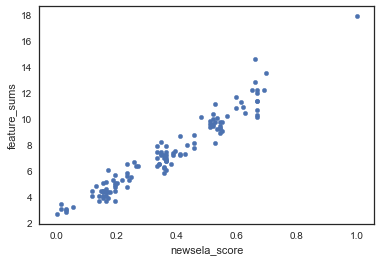

In [209]:
norm_df.plot.scatter(x="newsela_score",y="feature_sums")

In [210]:
norm_df.to_csv("data/newsela/norm_text_features.csv",sep=",",index=False)

## Apply Regression Model

* LogisticRegression
* LassoCV
* RidgeCV

In [211]:
norm_df = pd.read_csv("data/newsela/norm_text_features.csv",sep=",")

In [239]:
def train_eval_model(x_train,y_train,x_test,y_test,model_fn):
    model = model_fn()
    
    model.fit(x_train,y_train)
    
    print("Evaluation: \n Score: {} \n Feature Importance:".format(model.score(x_train,y_train)))
    for row in zip(*[x_train.columns,model.coef_]):
        print(row)
    
    print("Prediction: ")
    print(model.predict(x_test))
    print("Actual: ")
    print(y_test)
    
    return model

In [240]:
def eval_exclude_cols(df,feature_cols,exclude,x_test,y_test,model_fn):
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    x_train = df[col_without]
    y_train = df["newsela_score"]
    
    x_test = [row[bool_without] for row in x_test]
    
    return train_eval_model(
        x_train,y_train,x_test,y_test,model_fn)

In [214]:
#test article
test_articles = []
for file_name,newsela_score in [("43643-1040.txt",1040),("43643-580.txt",580),("43643-800.txt",800)]:
    with codecs.open("data/newsela/test/"+file_name, "r",encoding='utf-8', errors='ignore') as f:
            score = np.concatenate(ts.score(f.read()))
            test_articles += [(score,newsela_score)]
X_test,y_test = list(zip(*test_articles))
X_test,y_test = np.array(X_test),np.array(y_test)

y_test_norm = (y_test - y_test.mean())/y_test.std()

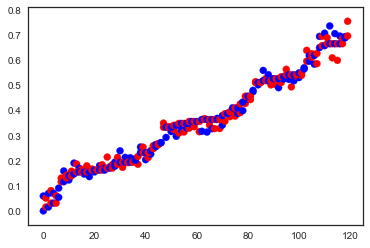

In [241]:
sorted_data = norm_df[norm_df["text"] != "LSAT"].sort_values("newsela_score",ascending=True)
X_sorted = sorted_data[feature_cols].values
y_sorted = sorted_data["newsela_score"]
model = linear_model.RidgeCV()
model.fit(norm_df[feature_cols],norm_df["newsela_score"])
predictions = model.predict(X_sorted)
plt.scatter(x=[range(len(sorted_data)),range(len(sorted_data))],y=[predictions,y_sorted],c=["blue","red"])

In [242]:
model.predict(norm_df[norm_df["text"] == "LSAT"][feature_cols])

array([ 1.020573])

### All Attributes

In [218]:
norm_df.head()

,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas,feature_sums
0,44452,0.689922,0.622600,0.566434,0.370854,0.671875,0.445115,0.278846,0.639388,0.282051,...,0.248500,0.667234,0.730289,0.740026,0.713405,0.321819,0.533653,0.578018,0.590893,12.182659
1,44089,0.232558,0.164249,0.164983,0.268122,0.298611,0.489862,0.000000,0.148429,0.162963,...,0.159035,0.176009,0.843990,0.336162,0.168318,0.171498,0.145614,0.228002,0.173622,5.576508
2,44271,0.542636,0.267647,0.385124,0.417968,0.146591,0.661314,0.263636,0.477403,0.213333,...,0.185759,0.440659,0.700585,0.428066,0.526024,0.628532,0.432266,0.207549,0.401473,9.418221
3,43993,0.348837,0.349888,0.506818,0.325233,0.083984,0.206661,0.000000,0.558466,0.366667,...,0.133148,0.232672,0.857562,0.201298,0.499431,0.468423,0.372638,0.375912,0.315941,7.456663
4,44384,0.379845,0.309138,0.327592,0.102571,0.047149,0.174030,0.508772,0.158585,0.205848,...,0.135215,0.232672,0.742742,0.367352,0.277196,0.326989,0.317675,0.189685,0.282803,6.511182


In [243]:
#RidgeCV
model = eval_exclude_cols(
    norm_df,
    feature_cols,
    [],
    X_test,
    y_test,
    linear_model.RidgeCV
)

Evaluation: 
 Score: 0.9782118847315117 
 Feature Importance:
('Subordination', 0.048822312263369472)
('Complements', 0.048186195991493402)
('Coordination', -0.012496350408886071)
('Apposition', -0.0003407134839821176)
('Passive verbs', -0.0025133499136254186)
('Parataxis', 0.029143053138179525)
('Auxiliary Verbs', 0.0067038490896661205)
('Negation', 0.017083073800836925)
('Prepositional Phrases', 0.19087129772493466)
('Modifiers', 0.073581677095847522)
('Mean word length', 0.094175409092050355)
('Mean sentence length', 0.24542746584959238)
('Basic english ratio', 0.065933452458103309)
('Syllables per sentence', 0.14150571136037324)
('Type token ratio', 0.051594535829185544)
('#nouns', 0.193422495211128)
('#verbs', 0.14817109940725415)
('#adjectives', -0.037469352356858561)
('#adverbs', 0.056963830479271296)
('#pronouns', -0.043118264819076109)
('#commas', 0.071099962107204276)
Prediction: 
[ 10.36100593   6.24420919   7.92948314]
Actual: 
[1040  580  800]


In [244]:
max_file_scores = model.predict(df.loc[df["newsela_score"] == "max"][feature_cols])
max_text_predictions = (zip(*[df.loc[df["newsela_score"] == "max"]["text"],max_file_scores]))
max_newsela_scores = norm_df.groupby("text").max().reset_index()

In [245]:
max_text_predictions = [(ID,pred_score,max_newsela_scores.loc[max_newsela_scores["text"] == ID]["newsela_score"].get_values()[0]) for ID,pred_score in max_text_predictions]
max_text_predictions

[('44266', 0.66412653129777277, 0.5968992248062015),
 ('44331', 0.83898871221908422, 0.65891472868217049),
 ('44581', 0.7118198684715612, 0.62790697674418605),
 ('44352', 0.3750401366433132, 0.33333333333333331),
 ('44118', 0.49500309380771523, 0.48062015503875971),
 ('44482', 0.76908456898934019, 0.66666666666666663),
 ('44452', 0.76040960541263658, 0.68992248062015504),
 ('44442', 0.45987307498576568, 0.34108527131782945),
 ('44322', 1.0560777750101371, 0.65116279069767447),
 ('44221', 0.40763407757186526, 0.4573643410852713),
 ('44428', 0.59146496453154052, 0.54263565891472865),
 ('44367', 0.69403899292973525, 0.61240310077519378),
 ('43993', 0.49692829542099726, 0.41085271317829458),
 ('44453', 0.69316320556260858, 0.66666666666666663),
 ('42157', 0.6343504860367295, 0.51162790697674421),
 ('44271', 0.90304865839420623, 0.65891472868217049),
 ('44107', 1.1877931844896268, 0.69767441860465118),
 ('44508', 0.78534117665552572, 0.66666666666666663),
 ('44300', 0.73517969361390623, 0.5

In [246]:
#Mean Increases between the highest newsela score and the "max" text score
np.mean([pred/max_newsela for ID,pred,max_newsela in max_text_predictions])

1.2653173139500782

In [247]:
#LSAT Text Prediction
model.predict(plot_df[plot_df["text"] == "LSAT"][feature_cols])

array([ 1.020573])

## Feature Correlation

In [ ]:
#TODO: Feature Correlation each by each

### Plot Correlation Matrix

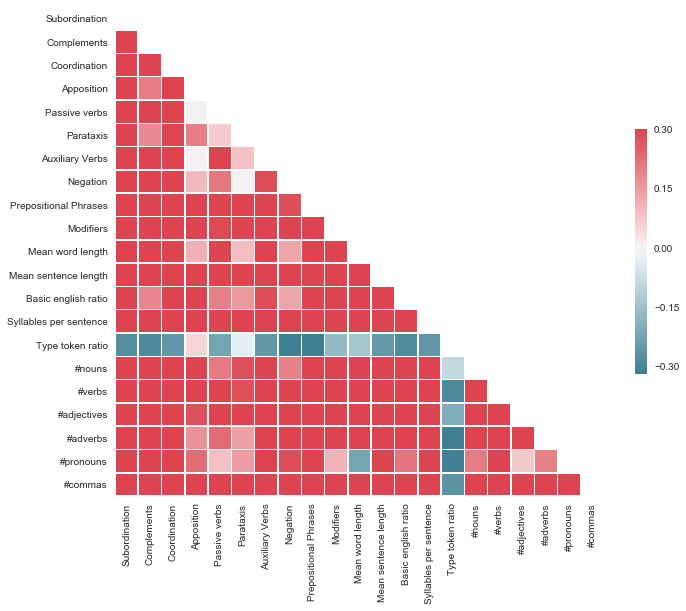

In [126]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = plot_df[plot_df.columns[2:-1]]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})